In [1]:
from Utils.Solver import *
from Utils.Signals import *

In [2]:
# Let's assume we are interested in the following stocks: AAPL, MSFT, TSLA, AMZN, GOOG
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOG']
# Signal scores for AAPL, MSFT, TSLA, AMZN, GOOG
signal_scores = np.array([1.0, 1.5, 0.5, 0.25, 1.75])  # Example signal scores
start_date ='2021-01-15'
end_date ='2022-01-15'

# Step 1: Download historical stock data
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


## Signals 

In [3]:
import yfinance as yf
import talib as ta
import pandas as pd
import numpy as np

# Fetch stock data
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOG']
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')

[*********************100%***********************]  5 of 5 completed


### RSI SIGNAL

In [4]:
# Calculate the RSI signal scores
rsi_signal_scores = calculate_rsi_signal(data, tickers, date='2022-12-23', period=14)
rsi_scores = [score[1] for score in rsi_signal_scores]
rsi_scores_array = np.array(rsi_scores)
print(rsi_scores_array)

[35.69462405 44.14051224 19.81992342 38.02756082 40.44855497]


     pcost       dcost       gap    pres   dres
 0: -1.2478e-01 -1.1479e+00  1e+00  0e+00  3e+00
 1: -1.2557e-01 -1.5230e-01  3e-02  1e-16  7e-02
 2: -1.2688e-01 -1.2801e-01  1e-03  7e-17  1e-03
 3: -1.2692e-01 -1.2694e-01  2e-05  4e-17  1e-05
 4: -1.2692e-01 -1.2692e-01  2e-07  7e-17  1e-07
 5: -1.2692e-01 -1.2692e-01  2e-09  1e-16  1e-09
Optimal solution found.
Optimized Portfolio Weights:
{'AAPL': np.float64(0.2004799005352185), 'MSFT': np.float64(0.25974723636638986), 'TSLA': np.float64(0.08908238166961202), 'AMZN': np.float64(0.21685081892790067), 'GOOG': np.float64(0.23383966250087893)}
Final Portfolio Weights: [0.2004799  0.25974724 0.08908238 0.21685082 0.23383966]


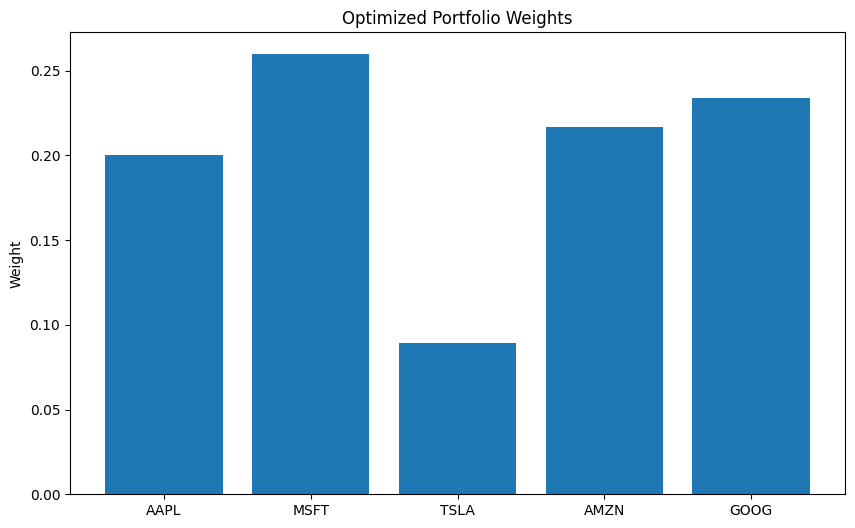

In [5]:
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)
rsi_portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, rsi_scores_array)
print("Final Portfolio Weights:", rsi_portfolio_weights)
portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=rsi_portfolio_weights)

Total Portfolio Return: 147.66%
Annualized Portfolio Return: 147.66%


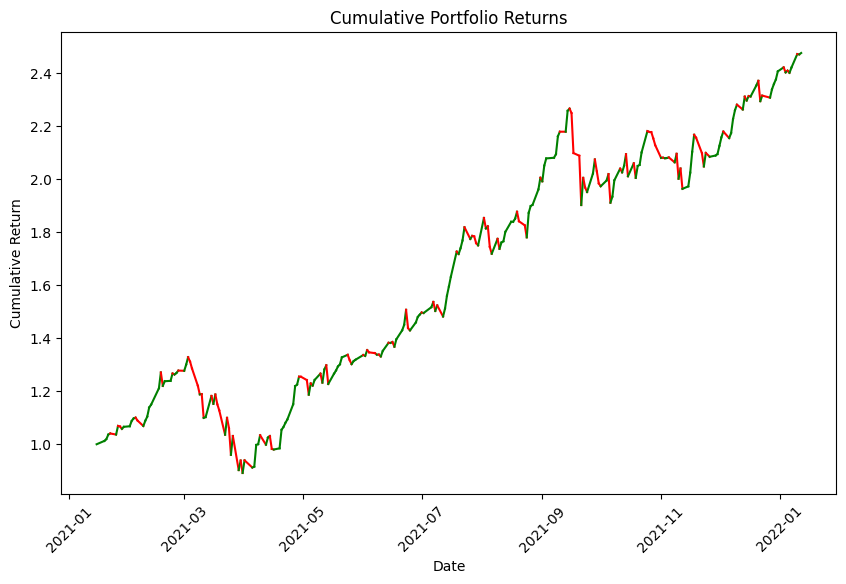

In [6]:
# Calculate portfolio returns and performance
cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, rsi_portfolio_weights)
# Show the portfolio performance plot
portfolio_solver.ShowPortfolioPerformance(cumulative_returns, data, start_date, end_date)

### MACD signal

In [7]:
# Calculate MACD for a specific date (e.g., '2021-01-15')
macd_signal = calculate_macd_signal(data, tickers, '2021-01-15')
macd_scores = [score[1] for score in macd_signal]
macd_scores_array = np.array(macd_scores)

     pcost       dcost       gap    pres   dres
 0: -5.1576e+00 -3.2420e+00  2e+01  5e+00  1e+00
 1: -9.9484e-01 -1.9725e+00  1e+00  9e-03  2e-03
 2: -1.0944e+00 -1.1813e+00  9e-02  7e-04  2e-04
 3: -1.1233e+00 -1.1306e+00  7e-03  2e-05  4e-06
 4: -1.1260e+00 -1.1268e+00  8e-04  1e-17  3e-16
 5: -1.1262e+00 -1.1262e+00  7e-05  1e-17  1e-16
 6: -1.1262e+00 -1.1262e+00  9e-07  7e-18  4e-17
Optimal solution found.
Optimized Portfolio Weights:
{'AAPL': np.float64(0.33481698770908996), 'MSFT': np.float64(0.6384754490055028), 'TSLA': np.float64(3.039818702356101e-09), 'AMZN': np.float64(0.026707544948782056), 'GOOG': np.float64(1.5296806441260906e-08)}
Final Portfolio Weights: [3.34816988e-01 6.38475449e-01 3.03981870e-09 2.67075449e-02
 1.52968064e-08]


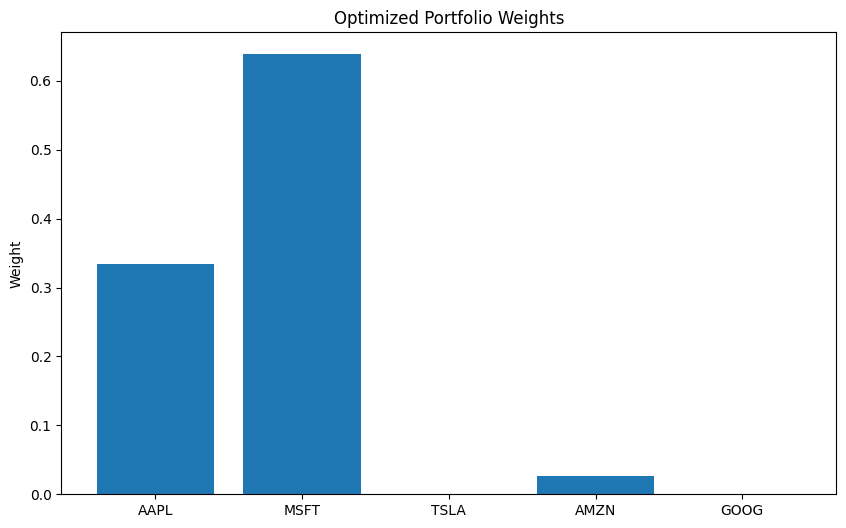

In [8]:
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)
macd_portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, macd_scores_array)
print("Final Portfolio Weights:", macd_portfolio_weights)
portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=macd_portfolio_weights)

Total Portfolio Return: 76.57%
Annualized Portfolio Return: 76.57%


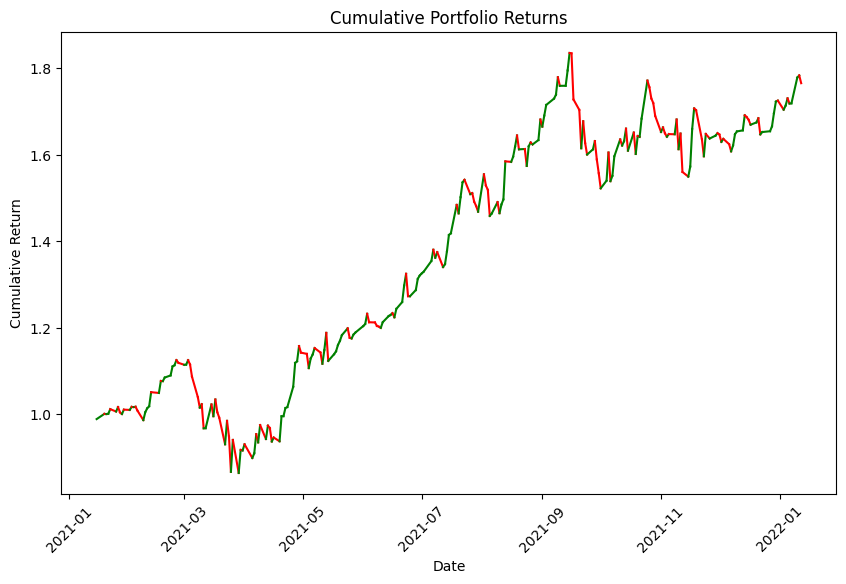

In [9]:
# Calculate portfolio returns and performance
cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, macd_portfolio_weights)
# Show the portfolio performance plot
portfolio_solver.ShowPortfolioPerformance(cumulative_returns, data, start_date, end_date)

### SMA signal

In [10]:
# Calculate SMA crossover signal for a specific date (e.g., '2021-01-15')
sma_signal = calculate_sma_signal(data, tickers, '2021-01-15')
sma_scores = [score[1] for score in sma_signal]
sma_scores_array = np.array(sma_scores)
print(sma_scores_array)

SIGNAL SCORES [['AAPL', np.float64(19.993315391540534)], ['MSFT', np.float64(13.46059738159181)], ['TSLA', np.float64(81.52420953750611)], ['AMZN', np.float64(11.691670494079602)], ['GOOG', np.float64(11.394829769134532)]]
[19.99331539 13.46059738 81.52420954 11.69167049 11.39482977]


     pcost       dcost       gap    pres   dres
 0: -2.0345e-01 -1.3608e+00  1e+00  0e+00  3e+00
 1: -2.2219e-01 -3.2681e-01  1e-01  1e-16  3e-01
 2: -2.3998e-01 -2.5115e-01  1e-02  2e-16  5e-17
 3: -2.4069e-01 -2.4133e-01  6e-04  1e-16  4e-17
 4: -2.4070e-01 -2.4071e-01  8e-06  1e-16  2e-17
 5: -2.4070e-01 -2.4070e-01  8e-08  6e-17  1e-17
Optimal solution found.
Optimized Portfolio Weights:
{'AAPL': np.float64(0.13101378365542002), 'MSFT': np.float64(0.07186851764853477), 'TSLA': np.float64(0.688097954363357), 'AMZN': np.float64(0.0558535444329706), 'GOOG': np.float64(0.053166199899717694)}
Final Portfolio Weights: [0.13101378 0.07186852 0.68809795 0.05585354 0.0531662 ]


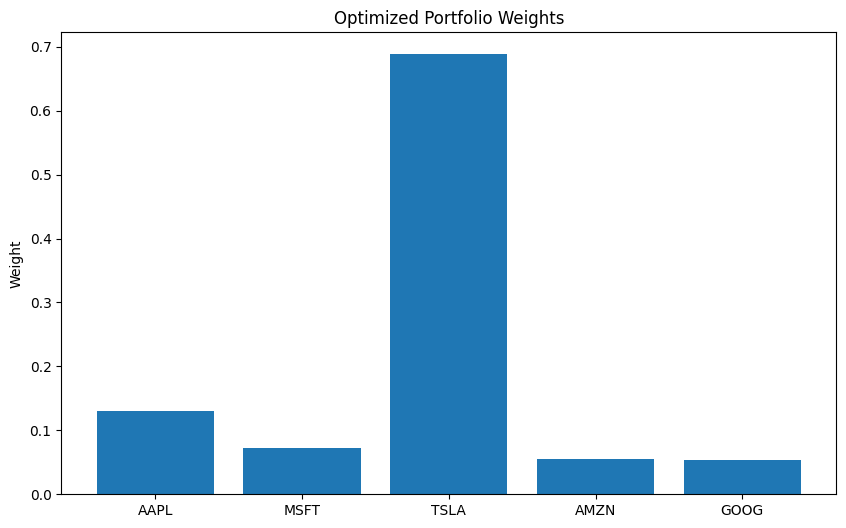

In [11]:
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)
sma_portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, sma_scores_array)
print("Final Portfolio Weights:", sma_portfolio_weights)
portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=sma_portfolio_weights)

Total Portfolio Return: 54.65%
Annualized Portfolio Return: 54.65%


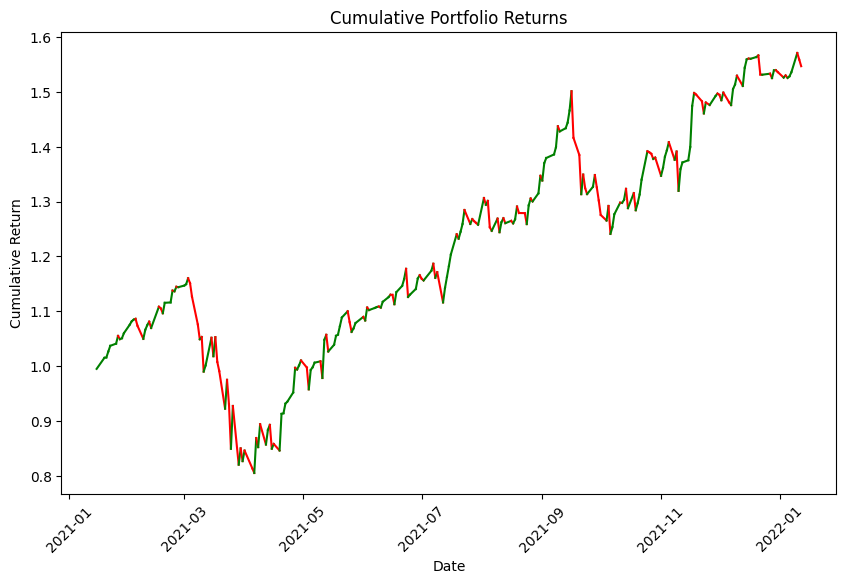

In [12]:
# Calculate portfolio returns and performance
cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, sma_portfolio_weights)
# Show the portfolio performance plot
portfolio_solver.ShowPortfolioPerformance(cumulative_returns, data, start_date, end_date)

rsi_signal_scores [48.09327814 42.67419424 66.28230185 42.67309414 46.45338814]
macd_signal_scores [-0.81745097 -0.98491296  1.88721933 -0.64751188 -0.12669522]
SIGNAL SCORES [['AAPL', np.float64(19.993315391540534)], ['MSFT', np.float64(13.46059738159181)], ['TSLA', np.float64(81.52420953750611)], ['AMZN', np.float64(11.691670494079602)], ['GOOG', np.float64(11.394829769134532)]]
sma_signal_scores [19.99331539 13.46059738 81.52420954 11.69167049 11.39482977]
[ 67.26914256  55.14987866 149.69373072  53.71725276  57.72152269]
     pcost       dcost       gap    pres   dres
 0: -1.3988e-01 -1.2314e+00  1e+00  2e-16  3e+00
 1: -1.4431e-01 -2.1518e-01  7e-02  1e-16  2e-01
 2: -1.4874e-01 -1.5166e-01  3e-03  7e-17  4e-17
 3: -1.4876e-01 -1.4879e-01  3e-05  8e-17  2e-17
 4: -1.4876e-01 -1.4876e-01  3e-07  5e-17  3e-17
 5: -1.4876e-01 -1.4876e-01  3e-09  7e-17  3e-17
Optimal solution found.
Optimized Portfolio Weights:
{'AAPL': np.float64(0.16923110925696777), 'MSFT': np.float64(0.12973425863

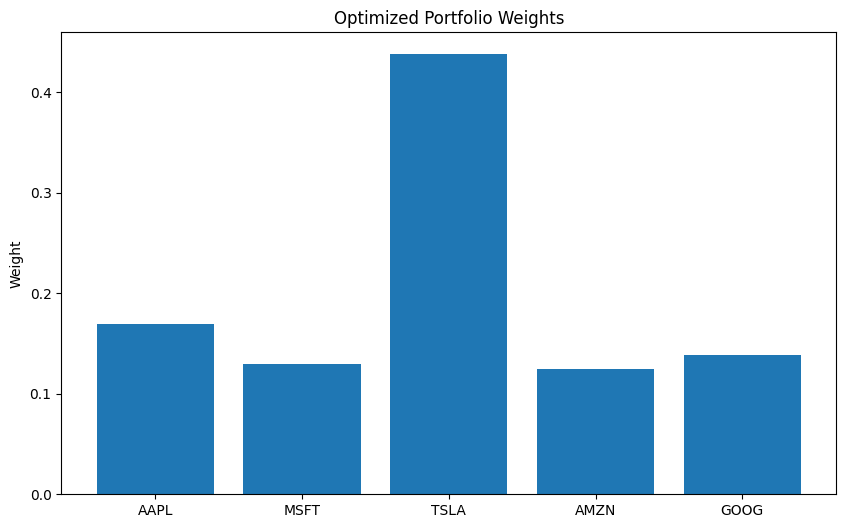

Total Portfolio Return: 92.24%
Annualized Portfolio Return: 92.24%


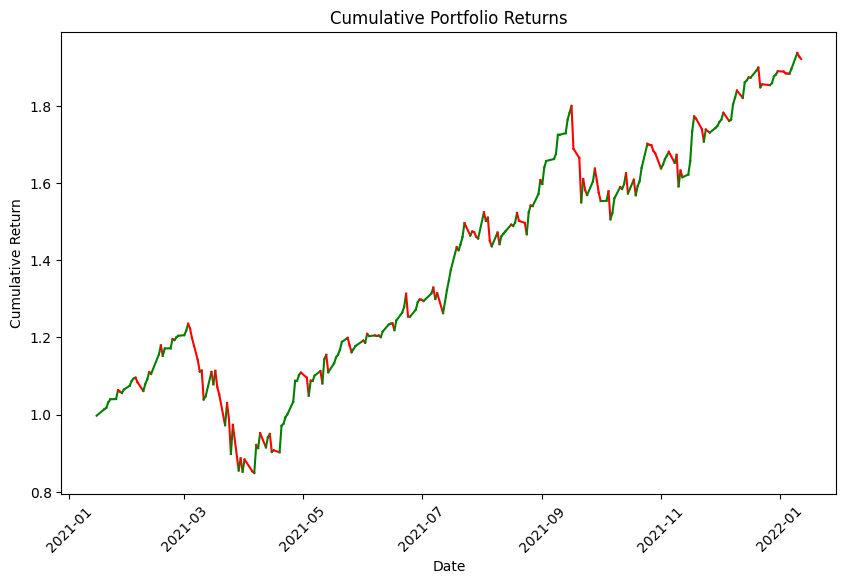

In [13]:

trading_dates = ['2021-01-15']
# Example of Iterative Optimization
for date in trading_dates:
    # Step 1: Calculate the signals for this specific date
    rsi_signal_scores = calculate_rsi_signal(data, tickers, date, period=14)
    rsi_scores_array = np.array([score[1] for score in rsi_signal_scores])
    print("rsi_signal_scores", rsi_scores_array)

    macd_signal_scores = calculate_macd_signal(data, tickers, date)
    macd_scores_array = np.array([score[1] for score in macd_signal_scores])
    print("macd_signal_scores", macd_scores_array)

    sma_signal_scores = calculate_sma_signal(data, tickers, date)
    sma_scores_array = np.array([score[1] for score in sma_signal_scores])
    print("sma_signal_scores", sma_scores_array)


    # Step 2: Combine the signals into a single combined score
    signal_weights = [1,1,1]
    signal_scores = [rsi_scores_array, macd_scores_array, sma_scores_array]
    combined_scores = combine_signals(signal_weights, signal_scores)
    print(combined_scores)
    
    # Step 3: Optimize portfolio based on the combined signal scores
    portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, combined_scores)
    portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=portfolio_weights)
    
    # Step 4: Update the portfolio weights for this date
    cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, portfolio_weights)
    #cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, sma_portfolio_weights)
    # Optionally, store the results or plot the performance over time
    portfolio_solver.ShowPortfolioPerformance(cumulative_returns, data, start_date=date, end_date='2022-01-15')
    


# Prepare data

In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
from Utils.Solver import *
from Utils.Signals import *


# Download historical stock data
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOG']
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')

# Initialize the portfolio solver with appropriate penalty and max weight threshold
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)

# Define the target date range
start_date = '2021-01-01'
end_date = '2022-01-01'
date_range = pd.date_range(start=start_date, end=end_date)

# Initialize an empty list to store the rows of the dataset
dataset = []

# Iterate over each date in the target range to calculate the signals and portfolio returns
for date in date_range:
    print(f"processing {date}")

    # Step 1: Calculate the RSI signal scores
    rsi_signal_scores = calculate_rsi_signal(data, tickers, date=date, period=14)
    rsi_scores = np.array([score[1] for score in rsi_signal_scores])

    # Step 2: Calculate the MACD signal scores
    macd_signal_scores = calculate_macd_signal(data, tickers, date=date)
    macd_scores = np.array([score[1] for score in macd_signal_scores])

    # Step 3: Calculate the SMA signal scores
    sma_signal_scores = calculate_sma_signal(data, tickers, date=date)
    sma_scores = np.array([score[1] for score in sma_signal_scores])

    if np.any(np.isnan(rsi_scores)) or np.any(np.isnan(macd_scores)) or np.any(np.isnan(sma_scores)):
        print(f"Skipping {date} due to NaN values in the signals.")
        continue  # Skip this date and move to the next one

    print(f"RSI : {rsi_signal_scores}")
    print(f"MACD : {macd_signal_scores}")
    print(f"SMA : {sma_scores}")

    # Step 4: Combine the signals (this step can be adjusted later based on how you combine them)
    signal_weights = [1, 1, 1]  # You can later train a model to adjust these weights
    combined_scores = combine_signals(signal_weights, [rsi_scores, macd_scores, sma_scores])
    combined_scores_with_tickers = list(zip(tickers, combined_scores))

    print(f"Combined Scores", combined_scores_with_tickers)
    
    # Step 5: Solve the portfolio based on the combined signal scores
    portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, combined_scores)

    # Step 6: Calculate the returns for the portfolio based on the optimized weights
    cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, portfolio_weights, start_date=date, time_period=30)  # time_period=1 for daily returns
    
    # Add the calculated values to the dataset
    dataset.append({
        'date': date,
        'rsi_scores': rsi_scores,
        'macd_scores': macd_scores,
        'sma_scores': sma_scores,
        'combined_scores': combined_scores,
        'portfolio_weights': portfolio_weights,
        'total_return': total_return,
        'annualized_return': annualized_return
    })


# Convert the dataset into a DataFrame
df = pd.DataFrame(dataset)

# Display the dataset (this will include the RSI, MACD, SMA scores, portfolio weights, and returns)

# You can now use this DataFrame for training your model.
display(df)

[*********************100%***********************]  5 of 5 completed


processing 2021-01-01 00:00:00
SIGNAL SCORES [['AAPL', nan], ['MSFT', nan], ['TSLA', nan], ['AMZN', nan], ['GOOG', nan]]
Skipping 2021-01-01 00:00:00 due to NaN values in the signals.
processing 2021-01-02 00:00:00
SIGNAL SCORES [['AAPL', nan], ['MSFT', nan], ['TSLA', nan], ['AMZN', nan], ['GOOG', nan]]
Skipping 2021-01-02 00:00:00 due to NaN values in the signals.
processing 2021-01-03 00:00:00
SIGNAL SCORES [['AAPL', nan], ['MSFT', nan], ['TSLA', nan], ['AMZN', nan], ['GOOG', nan]]
Skipping 2021-01-03 00:00:00 due to NaN values in the signals.
processing 2021-01-04 00:00:00
SIGNAL SCORES [['AAPL', np.float64(20.081625595092774)], ['MSFT', np.float64(14.962106018066407)], ['TSLA', np.float64(67.97656603813171)], ['AMZN', np.float64(14.464915924072272)], ['GOOG', np.float64(11.452275085449216)]]
RSI : [['AAPL', np.float64(54.9575893555832)], ['MSFT', np.float64(48.90808775712788)], ['TSLA', np.float64(71.86002956306031)], ['AMZN', np.float64(48.36221551762188)], ['GOOG', np.float64(45.

,date,rsi_scores,macd_scores,sma_scores,combined_scores,portfolio_weights,total_return,annualized_return
0,2021-01-04,"[54.9575893555832, 48.90808775712788, 71.86002...","[0.039760469929781106, -0.03355970343359482, 0...","[20.081625595092774, 14.962106018066407, 67.97...","[75.07897542060576, 63.83663407176069, 140.261...","[0.18548619600169813, 0.1502244469628479, 0.38...",0.128082,1.752078
1,2021-01-05,"[57.72292901376562, 49.294442207584495, 72.475...","[-0.1463180912457065, -0.308796146934434, 0.81...","[20.02195207595824, 14.637325820922854, 68.956...","[77.59856299847816, 63.622971881572916, 142.24...","[0.18736824253940607, 0.1446179506493419, 0.38...",0.119915,1.589127
2,2021-01-06,"[48.8253673317137, 40.43519572817152, 74.79375...","[-0.5603180036994697, -0.8311077803538811, 1.3...","[19.905601329803474, 14.19844535827636, 70.076...","[68.1706506578177, 53.802533306094, 146.201578...","[0.17201365302744465, 0.1252205290875713, 0.42...",0.133032,1.855184
3,2021-01-07,"[55.983079219271744, 50.64665485419481, 80.012...","[-0.5499988355043612, -0.7593168174496716, 2.7...","[19.879665126800546, 14.024465560913086, 71.52...","[75.31274551056794, 63.91180359765822, 154.263...","[0.17303027725543407, 0.13926766603609994, 0.4...",0.080958,0.923067
4,2021-01-08,"[57.65159635288018, 52.574603637563634, 83.848...","[-0.47186628563422905, -0.6071579363485846, 4....","[19.83840717315674, 13.801933593749993, 73.271...","[77.0181372404027, 65.76937929496503, 161.8009...","[0.16961665065369325, 0.13754090426033236, 0.4...",0.026499,0.245697
...,...,...,...,...,...,...,...,...
247,2021-12-27,"[66.9067285376611, 59.340761141268985, 58.3541...","[-0.12650095855383015, 0.2901714816678572, 2.5...","[16.691499786376966, 43.1911841583252, 89.7060...","[83.47172736548423, 102.82211678126204, 150.58...","[0.17885919745669837, 0.23191326513285568, 0.3...",-0.076719,-0.488548
248,2021-12-28,"[64.96681004685553, 58.19974014560266, 57.6581...","[-0.06132470537192791, 0.7186033144069275, 3.9...","[17.098226394653324, 43.39802764892579, 90.708...","[82.00371173613692, 102.31637110893539, 152.28...","[0.17607384733422593, 0.23207327675118058, 0.3...",-0.060340,-0.407135
249,2021-12-29,"[65.06121742670351, 58.69866148260719, 57.3510...","[-0.05801220319437839, 0.9836006753746749, 4.5...","[17.480444984436048, 43.56929229736323, 91.466...","[82.48365020794517, 103.2515544553451, 153.394...","[0.17746732243399693, 0.23473951729080775, 0.3...",-0.048308,-0.340266
250,2021-12-30,"[62.6764974838435, 55.99465546867511, 55.15212...","[-0.17317037929774237, 0.9232954473379553, 4.4...","[17.797929878234868, 43.68068557739258, 92.226...","[80.30125698278061, 100.59863649340565, 151.82...","[0.17595165504178062, 0.23306441738307038, 0.3...",-0.062946,-0.420805


In [ ]:


X = np.array([[
    row['rsi_scores'][0],  # Assuming each column contains a list, we use the first element
    row['macd_scores'][0],  # Adjust this depending on what score you want to use from each list
    row['sma_scores'][0]    # Same for SMA
] for _, row in df.iterrows()])

display(X)

array([[ 5.49575894e+01,  3.97604699e-02,  2.00816256e+01],
       [ 5.77229290e+01, -1.46318091e-01,  2.00219521e+01],
       [ 4.88253673e+01, -5.60318004e-01,  1.99056013e+01],
       [ 5.59830792e+01, -5.49998836e-01,  1.98796651e+01],
       [ 5.76515964e+01, -4.71866286e-01,  1.98384072e+01],
       [ 5.18959694e+01, -6.16061518e-01,  1.98731558e+01],
       [ 5.15708404e+01, -7.10494092e-01,  1.98119352e+01],
       [ 5.50887317e+01, -6.25662818e-01,  1.99158982e+01],
       [ 5.12878007e+01, -6.85199698e-01,  1.99919753e+01],
       [ 4.80932781e+01, -8.17450968e-01,  1.99933154e+01],
       [ 4.94159694e+01, -8.33137169e-01,  1.99216894e+01],
       [ 5.66562743e+01, -5.54240334e-01,  1.98277615e+01],
       [ 6.31941366e+01, -6.41701715e-02,  1.98329385e+01],
       [ 6.57249690e+01,  3.68154236e-01,  1.99129605e+01],
       [ 6.96569552e+01,  8.43630215e-01,  2.00642856e+01],
       [ 6.98888644e+01,  1.09427579e+00,  2.01526917e+01],
       [ 6.73483306e+01,  1.10483976e+00

TODO: Calculate all the return for each of those dates

In [ ]:
import numpy as np
import pandas as pd

# Assuming your existing df is already loaded
# Extract features (signal scores) from the existing DataFrame
# We assume that each column (e.g., rsi_scores) is a list of multiple values.
# We'll extract the first value of each list for the model.

# Extract first values from the lists in each row
# TODO: Do for all companies !!!!!!!! THIS IS ONLY THE FIRST COMPANY
X = np.array([[
    row['rsi_scores'][0],  # Assuming each column contains a list, we use the first element
    row['macd_scores'][0],  # Adjust this depending on what score you want to use from each list
    row['sma_scores'][0]    # Same for SMA
] for _, row in df.iterrows()])

# Ensure the shape of X is correct (it should be 2D with each row representing a data point)
print("Shape of X:", X.shape)

# Target (returns), you can choose 'total_return' or 'annualized_return' based on your preference
y = df['total_return'].values.reshape(-1, 1)

# Initialize and train a linear model to learn the weight matrix W
# Using np.linalg.lstsq to solve the least squares problem, i.e., Y = XW
W, _, _, _ = np.linalg.lstsq(X, y, rcond=None)

# Output the learned weight matrix W
print("Learned Weight Matrix (W):", W)

Shape of X: (252, 3)
Learned Weight Matrix (W): [[ 0.00090616]
 [-0.05405254]
 [-0.00188633]]


TODO: Apply W to all and calculate the return on every date

# RENDU ICI 

In [16]:
# Let's test the model with some input signals (for example, RSI=0.4, MACD=0.5, SMA=1.8)
test_data = np.array([[0.4, 0.5, 1.8]])

# Ensure test_data has the same shape as the learned weight matrix
print("Shape of test_data:", test_data.shape)

weighted_values = test_data[0] * W.flatten()
print("Weighted values : ", weighted_values)
# Predicted return (make sure the shapes are aligned)

#TODO: Solve Portfolio
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)
portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, weighted_values)
print("Final Portfolio Weights:", portfolio_weights)
portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=rsi_portfolio_weights)

#TODO: Display



print("Predicted Return for input [RSI=0.4, MACD=0.5, SMA=1.8]:", )

Shape of test_data: (1, 3)
Weighted values :  [-9.58326162e-05  1.10664726e-04  1.69205320e-03]


TypeError: 'P' must be a 'd' matrix of size (3, 3)

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from Utils.Solver import *
from Utils.Signals import *


# Download historical stock data
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOG']
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')

# Initialize the portfolio solver with appropriate penalty and max weight threshold
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)

# Define the target date range
start_date = '2022-01-01'
end_date = '2022-05-05'
date_range = pd.date_range(start=start_date, end=end_date)

# Initialize an empty list to store the rows of the dataset
res_dataset = []

# Iterate over each date in the target range to calculate the signals and portfolio returns
for date in date_range:
    print(f"processing {date}")

    # Step 1: Calculate the RSI signal scores
    rsi_signal_scores = calculate_rsi_signal(data, tickers, date=date, period=14)
    rsi_scores = np.array([score[1] for score in rsi_signal_scores])

    # Step 2: Calculate the MACD signal scores
    macd_signal_scores = calculate_macd_signal(data, tickers, date=date)
    macd_scores = np.array([score[1] for score in macd_signal_scores])

    # Step 3: Calculate the SMA signal scores
    sma_signal_scores = calculate_sma_signal(data, tickers, date=date)
    sma_scores = np.array([score[1] for score in sma_signal_scores])

    if np.any(np.isnan(rsi_scores)) or np.any(np.isnan(macd_scores)) or np.any(np.isnan(sma_scores)):
        print(f"Skipping {date} due to NaN values in the signals.")
        continue  # Skip this date and move to the next one

    print(f"RSI : {rsi_signal_scores}")
    print(f"MACD : {macd_signal_scores}")
    print(f"SMA : {sma_scores}")

    # Step 4: Combine the signals (this step can be adjusted later based on how you combine them)

    signal_weights = W  # You can later train a model to adjust these weights
    combined_scores = combine_signals(signal_weights, [rsi_scores, macd_scores, sma_scores])


    # Step 5: Solve the portfolio based on the combined signal scores
    portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, combined_scores)

    # Step 6: Calculate the returns for the portfolio based on the optimized weights
    cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, portfolio_weights, start_date=date, time_period=30)  # time_period=1 for daily returns
    
    # Add the calculated values to the dataset
    res_dataset.append({
        'date': date,
        'rsi_scores': rsi_scores,
        'macd_scores': macd_scores,
        'sma_scores': sma_scores,
        'combined_scores': combined_scores,
        'portfolio_weights': portfolio_weights,
        'total_return': total_return,
        'annualized_return': annualized_return
    })


# Convert the dataset into a DataFrame
res_data = pd.DataFrame(res_dataset)

# Display the dataset (this will include the RSI, MACD, SMA scores, portfolio weights, and returns)


# You can now use this DataFrame for training your model.
display(res_data)

In [ ]:
for date in trading_dates:
    # Step 1: Calculate the signals for this specific date
    rsi_signal_scores = calculate_rsi_signal(data, tickers, date, period=14)
    rsi_scores_array = np.array([score[1] for score in rsi_signal_scores])
    print("rsi_signal_scores", rsi_scores_array)

    macd_signal_scores = calculate_macd_signal(data, tickers, date)
    macd_scores_array = np.array([score[1] for score in macd_signal_scores])
    print("macd_signal_scores", macd_scores_array)

    sma_signal_scores = calculate_sma_signal(data, tickers, date)
    sma_scores_array = np.array([score[1] for score in sma_signal_scores])
    print("sma_signal_scores", sma_scores_array)


    # Step 2: Combine the signals into a single combined score
    signal_weights = [1,1,1]
    signal_scores = [rsi_scores_array, macd_scores_array, sma_scores_array]
    combined_scores = combine_signals(signal_weights, signal_scores)
    print(combined_scores)
    
    # Step 3: Optimize portfolio based on the combined signal scores
    portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, combined_scores)
    portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=portfolio_weights)
    
    # Step 4: Update the portfolio weights for this date
    cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, portfolio_weights)
    #cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, sma_portfolio_weights)
    # Optionally, store the results or plot the performance over time
    portfolio_solver.ShowPortfolioPerformance(cumulative_returns, data, start_date=date, end_date='2022-01-15')
    

In [ ]:
%pip install sklearn

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

class SignalWeightModel(tf.keras.Model):
    def __init__(self):
        super(SignalWeightModel, self).__init__()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(32, activation='relu')
        self.output_layer = layers.Dense(3, activation='softmax')  # Three outputs: RSI, MACD, SMA weights

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.output_layer(x)

# Initialize the model
signal_weight_model = SignalWeightModel()
signal_weight_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')

In [ ]:
class PortfolioOptimizerRL:
    def __init__(self, model):
        self.model = model
        self.discount_factor = 0.99  # Discount factor for future rewards

    def train(self, tickers, data, signals, portfolio_solver, num_epochs=100):
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")
            for date in data.index:
                # Step 1: Prepare the current state (signal scores for each stock)
                rsi_signal_scores = calculate_rsi_signal(data, tickers, date)
                rsi_scores_array = np.array([score[1] for score in rsi_signal_scores])

                macd_signal_scores = calculate_macd_signal(data, tickers, date)
                macd_scores_array = np.array([score[1] for score in macd_signal_scores])

                sma_signal_scores = calculate_sma_signal(data, tickers, date)
                sma_scores_array = np.array([score[1] for score in sma_signal_scores])

                state = np.array([rsi_scores_array, macd_scores_array, sma_scores_array]).flatten()

                # Step 2: Predict the weights for each signal using the model
                predicted_weights = self.model(state.reshape(1, -1))

                # Step 3: Combine signals with the predicted weights
                combined_scores = combine_signals(predicted_weights[0].numpy(), [rsi_scores_array, macd_scores_array, sma_scores_array])
            
                # Check for NaN values in combined_scores
                if np.any(np.isnan(combined_scores)) or np.any(np.isinf(combined_scores)):
                    continue  # Skip this iteration if there are invalid values

                print(f"Optimized Portfolio Weights:\n{dict(zip(tickers, combined_scores))}")

                # Step 4: Use the portfolio solver to get the portfolio weights based on the combined scores
                portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, combined_scores)

                # Step 5: Calculate the portfolio return (reward)
                cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, portfolio_weights)
                reward = annualized_return  # or another performance metric

                # Step 6: Update the model based on the reward
                with tf.GradientTape() as tape:
                    # Forward pass
                    predicted_weights = self.model(state.reshape(1, -1))

                    # Calculate the loss (negative of the reward to minimize loss)
                    loss = -reward

                # Backpropagation
                grads = tape.gradient(loss, self.model.trainable_variables)
                self.model.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

                print(f"Date: {date}, Reward: {reward}, Loss: {loss}")

In [ ]:
# Initialize the portfolio solver
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)

# Initialize the reinforcement learning optimizer
rl_optimizer = PortfolioOptimizerRL(signal_weight_model)

# Train the model
rl_optimizer.train(tickers, data, signals=None, portfolio_solver=portfolio_solver, num_epochs=100)
